# Convolutional Neural Network (CNN)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb)
- Unofficial notebook (pytorch): [Github](https://github.com/terrence-ou/Generative-Deep-Learning-2nd-Edition-PyTorch-JAX/blob/main/PyTorch/chapter_02_deeplearning/02_CNN.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2

from torchinfo import summary
from torchmetrics.classification import Accuracy, ConfusionMatrix

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## 0. Parameters

In [ ]:
NUM_CLASSES = 10

## 1. Prepare the Data

### Dataset

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor(),
])

In [ ]:
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_val = int(len(dataset_test)*0.2)
n_test = len(dataset_test) - n_val

dataset_test, dataset_val = torch.utils.data.random_split(dataset_test, [n_test, n_val],
                                                          generator=torch.Generator().manual_seed(SEED))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Train: {len(dataset_train)}")
print(f"Val: {len(dataset_val)}")
print(f"Test: {len(dataset_test)}")

Train: 50000
Val: 2000
Test: 8000


In [ ]:
id2cls = {i: cls for i, cls in enumerate(dataset_train.classes)}
id2cls

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
dataset_val[0][0].shape, dataset_val[0][1]

(torch.Size([3, 32, 32]), 1)

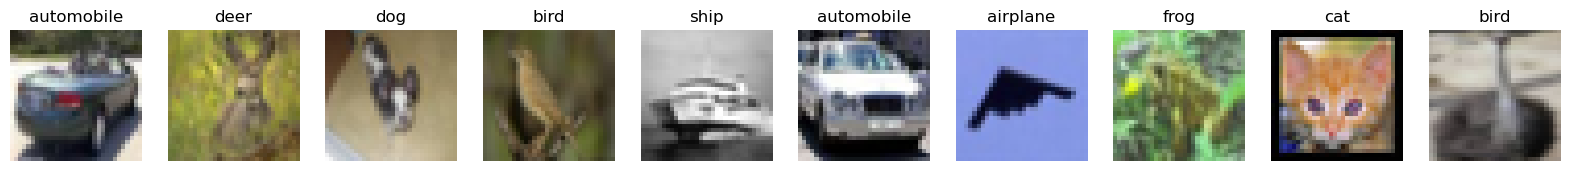

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(dataset_val[i][0].permute(1, 2, 0))
    plt.title(id2cls[dataset_val[i][1]])
    plt.axis("off")

plt.show()

### DataLoader

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
batch = next(iter(dataloader_val))
images, labels = batch
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

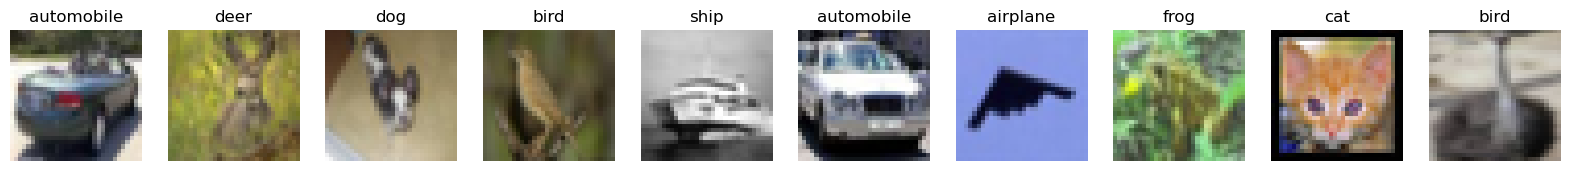

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(id2cls[labels[i].item()])
    plt.axis("off")

plt.show()

## 2. Build the model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.LazyConv2d(out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.LazyConv2d(out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.LazyLinear(128),
            nn.LazyBatchNorm1d(),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CNN(num_classes=NUM_CLASSES)
model = model.to(device)
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─LeakyReLU: 2-3                    [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 16, 16]           64
│    └─LeakyReLU: 2-6                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 16, 16]           128
│    └─LeakyReLU: 2-9                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-10                      [1, 64, 8, 8]             36,928
│    └─BatchNorm2d: 2-11                 [1, 64, 8, 8]             128
│

## 3. Train the model

In [ ]:
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("medium")

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

accuracy_train = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_train = accuracy_train.to(device)

accuracy_val = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_val = accuracy_val.to(device)

In [ ]:
metrics = {
    "train": {"loss": [], "accuracy": []},
    "val": {"loss": [], "accuracy": []},
}

results_dir = Path("results")
results_dir.mkdir(exist_ok=True, parents=True)

best_accuracy = 0

n_epochs = 10
for epoch in range(n_epochs):
    # Training
    model.train()

    loss_train = 0

    tqdm_train = tqdm(dataloader_train)
    tqdm_train.set_description("Epoch {:02d}/{:2d} (Train)".format(epoch+1, n_epochs))
    for batch in tqdm_train:
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        acc = accuracy_train(preds, labels)
        loss_train += loss.item()

        tqdm_train.set_postfix_str("loss {:.4f}, accuracy {:.4f}".format(loss.item(), acc.item()))


    loss_train = loss_train / len(dataloader_train)
    acc_train = accuracy_train.compute()
    accuracy_train.reset()

    print("(Train) loss {:.4f}, accuracy {:.4f}".format(loss_train, acc_train))
    metrics["train"]["loss"].append(loss_train)
    metrics["train"]["accuracy"].append(acc_train.item())

    torch.save(model.state_dict(), results_dir/"last.pth")

    # Validation
    model.eval()

    loss_val = 0
    
    tqdm_val = tqdm(dataloader_val)
    tqdm_val.set_description("Epoch {:02d}/{:2d} (Val)  ".format(epoch+1, n_epochs))
    for batch in tqdm_val:
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images)
            loss = criterion(logits, labels)

            preds = torch.argmax(logits, dim=1)
            accuracy_val.update(preds, labels)
            loss_val += loss.item()

    loss_val = loss_val / len(dataloader_val)
    acc_val = accuracy_val.compute()
    accuracy_val.reset()

    print("(Val)   loss {:.4f}, accuracy {:.4f}".format(loss_val, acc_val))
    metrics["val"]["loss"].append(loss_val)
    metrics["val"]["accuracy"].append(acc_val.item())

    if acc_val > best_accuracy:
        best_accuracy = acc_val
        torch.save(model.state_dict(), results_dir/"best.pth")

Epoch 01/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 104.47it/s, loss 1.4044, accuracy 0.3125]


(Train) loss 1.3636, accuracy 0.5152


Epoch 01/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 181.48it/s]


(Val)   loss 1.0753, accuracy 0.6195


Epoch 02/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 108.98it/s, loss 0.7440, accuracy 0.7500]


(Train) loss 1.0012, accuracy 0.6496


Epoch 02/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 177.29it/s]


(Val)   loss 0.9901, accuracy 0.6450


Epoch 03/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 106.91it/s, loss 0.9587, accuracy 0.6875]


(Train) loss 0.8564, accuracy 0.7030


Epoch 03/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 190.09it/s]


(Val)   loss 0.8342, accuracy 0.7085


Epoch 04/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 110.24it/s, loss 1.0157, accuracy 0.6250]


(Train) loss 0.7581, accuracy 0.7361


Epoch 04/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 189.07it/s]


(Val)   loss 0.7675, accuracy 0.7300


Epoch 05/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 109.78it/s, loss 0.4163, accuracy 0.7500]


(Train) loss 0.6867, accuracy 0.7610


Epoch 05/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 170.06it/s]


(Val)   loss 0.7951, accuracy 0.7165


Epoch 06/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 107.81it/s, loss 0.4786, accuracy 0.7500]


(Train) loss 0.6225, accuracy 0.7841


Epoch 06/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 178.27it/s]


(Val)   loss 0.7099, accuracy 0.7460


Epoch 07/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 106.40it/s, loss 1.1214, accuracy 0.6250]


(Train) loss 0.5584, accuracy 0.8049


Epoch 07/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 183.04it/s]


(Val)   loss 0.7809, accuracy 0.7375


Epoch 08/10 (Train): 100%|██████████| 1563/1563 [00:13<00:00, 111.97it/s, loss 0.6319, accuracy 0.7500]


(Train) loss 0.5108, accuracy 0.8223


Epoch 08/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 157.49it/s]


(Val)   loss 0.7165, accuracy 0.7640


Epoch 09/10 (Train): 100%|██████████| 1563/1563 [00:15<00:00, 102.60it/s, loss 0.2300, accuracy 0.9375]


(Train) loss 0.4655, accuracy 0.8367


Epoch 09/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 174.97it/s]


(Val)   loss 0.7534, accuracy 0.7635


Epoch 10/10 (Train): 100%|██████████| 1563/1563 [00:14<00:00, 106.11it/s, loss 0.3398, accuracy 0.8750]


(Train) loss 0.4279, accuracy 0.8480


Epoch 10/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 187.07it/s]

(Val)   loss 0.7548, accuracy 0.7470


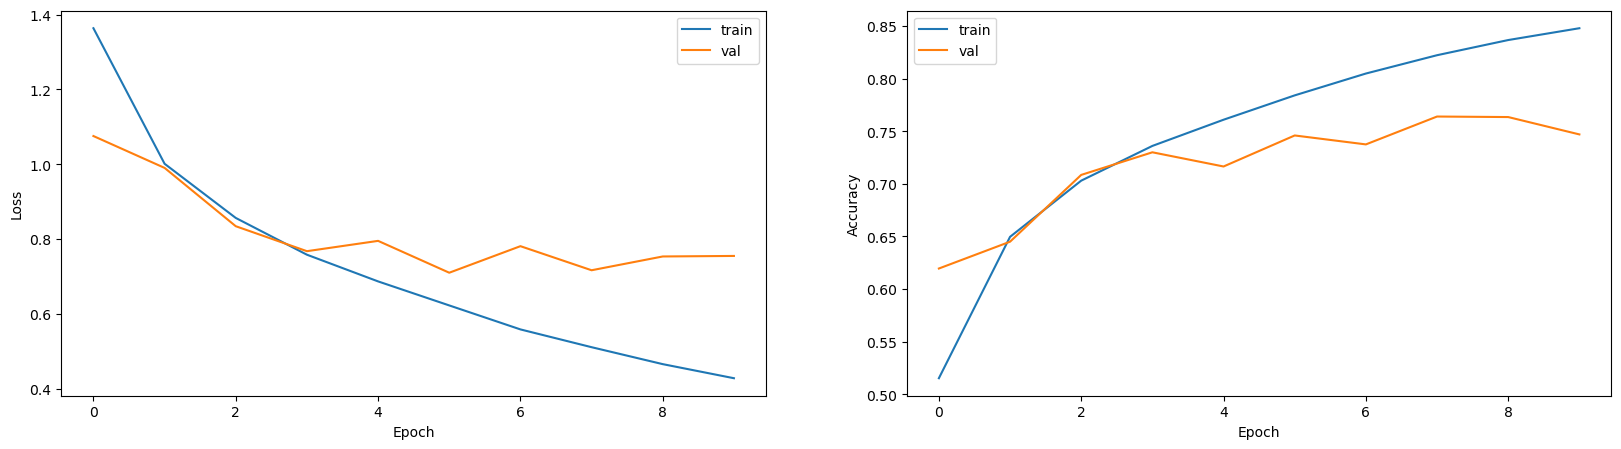

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
ax.plot(metrics["train"]["loss"], label="train")
ax.plot(metrics["val"]["loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = axes[1]
ax.plot(metrics["train"]["accuracy"], label="train")
ax.plot(metrics["val"]["accuracy"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

plt.show()

## 4. Evaluation

In [ ]:
model.load_state_dict(torch.load(results_dir/"best.pth", weights_only=True))
model.eval()

acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
acc = acc.to(device)

acc_per_cls = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average=None)
acc_per_cls = acc_per_cls.to(device)

confmat = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
confmat = confmat.to(device)

test_loss = 0
test_preds = []
test_labels = []
for batch in tqdm(dataloader_test):
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        logits = model(images)
        loss = criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)

        acc.update(preds, labels)
        acc_per_cls.update(preds, labels)
        confmat.update(preds, labels)
        test_loss += loss.item()

        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_loss = test_loss / len(dataloader_test)
test_acc = acc.compute()
acc.reset()
print("(Test)  loss {:.4f}, accuracy {:.4f}".format(test_loss, test_acc))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

100%|██████████| 250/250 [00:01<00:00, 140.98it/s]

(Test)  loss 0.6789, accuracy 0.7664


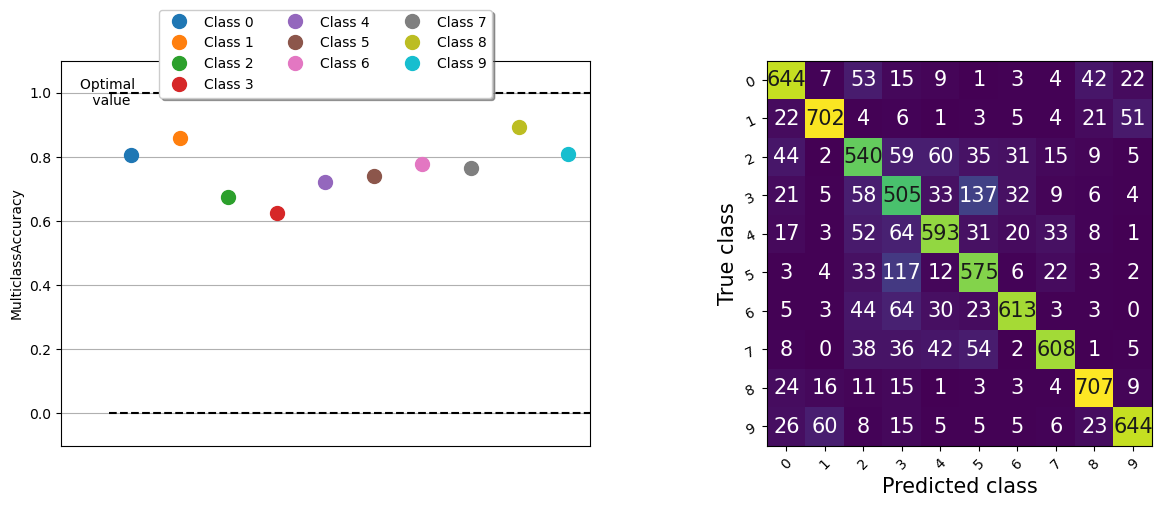

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc_per_cls.plot(ax=axes[0])
confmat.plot(ax=axes[1])
plt.show()

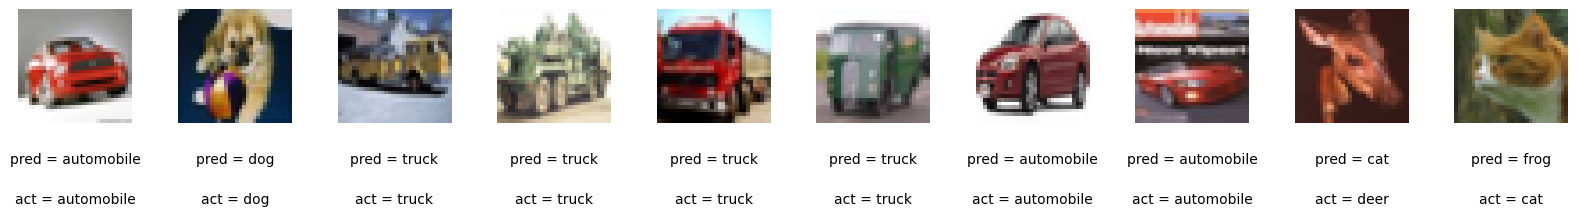

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dataset_test[idx][0].permute(1, 2, 0)
    
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + id2cls[test_preds[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + id2cls[test_labels[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)